In [ ]:
import os
import re
import string
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import *
from gensim.parsing.preprocessing import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import *
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier

# Linh tinh (*)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chọn thư mục hoạt động

HOME = '/content/drive/MyDrive/AI/ML'

!mkdir -p $HOME
%cd $HOME

/content/drive/MyDrive/AI/ML


In [ ]:
# Tạo các thư mục liên quan

!rm -rf models/toxic_comment/
!rm -rf logs/toxic_comment/
!rm -rf imgs/toxic_comment/

!mkdir -p datasets/toxic_comment/
!mkdir -p models/toxic_comment/
!mkdir -p logs/toxic_comment/
!mkdir -p imgs/toxic_comment/

In [ ]:
# Thiết lập đường dẫn chung

ds_path = 'datasets/toxic_comment/'
model_path = 'models/toxic_comment/'
log_path = 'logs/toxic_comment/'
img_path = 'imgs/toxic_comment/'

In [ ]:
# Clone data từ Git & move sang ds_path

!git clone https://github.com/tianqwang/Toxic-Comment-Classification-Challenge
!mv -f Toxic-Comment-Classification-Challenge/* $ds_path
!ls

fatal: destination path 'Toxic-Comment-Classification-Challenge' already exists and is not an empty directory.
mv: cannot stat 'Toxic-Comment-Classification-Challenge/*': No such file or directory
datasets  documents  imgs  logs  models  Toxic-Comment-Classification-Challenge


# Khái quát dữ liệu

In [ ]:
# Nạp data vào bộ nhớ

train_df = pd.read_csv(os.path.join(ds_path, 'data', 'train.csv'), delimiter=',')
test_df = pd.read_csv(os.path.join(ds_path, 'data', 'test.csv'), delimiter=',')

In [ ]:
# In thử 10 dòng đầu tiên tập Train

train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
# In thử 10 dòng cuối tập Test

test_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [ ]:
# Liệt kê các thuộc tính

train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
# Liệt kê các giá trị N/A, loại bỏ nếu có

train_df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [ ]:
# Kiểm tra giá trị ngoại lai

train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Phân bố dữ liệu ở các thuộc tính

In [ ]:
train_df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [ ]:
#tính tổng các giá trị lấy từ cột thứ 3
data_count=train_df.iloc[:,2:].sum().sort_values(ascending=False)
data_count

,0
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


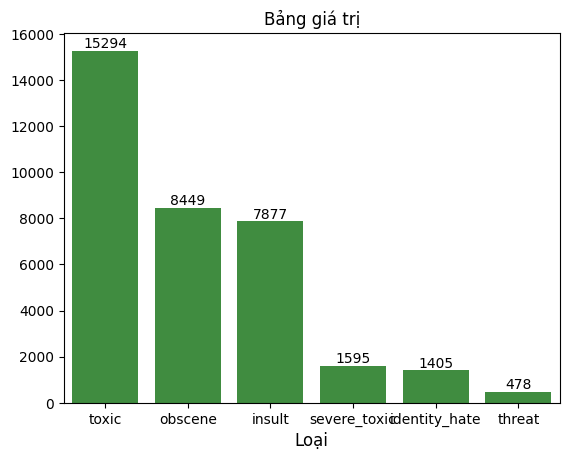

In [ ]:
#Sử dụng phương thức barplot trong Seaborn
#Hiển thị ước tính điểm và khoảng tin cậy dưới dạng thanh hình chữ nhật.
ax = sns.barplot(x=data_count.index, y=data_count.values, alpha=0.8, color='g')

plt.title("Bảng giá trị") # đặt tên biểu đồ
plt.ylabel("", fontsize=12)
plt.xlabel("Loại", fontsize=12) # đặt tên cho trục hoành , set font là 12

#Thêm text cho mỗi cột
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

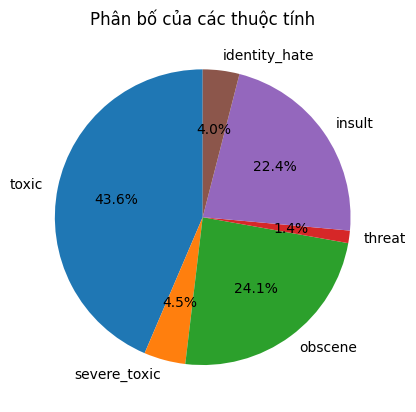

In [ ]:
# Tính tổng giá trị của 6 thuộc tính
column_sum = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

# Vẽ biểu đồ tròn
plt.pie(column_sum, labels=column_sum.index, autopct='%1.1f%%', startangle=90)
plt.title('Phân bố của các thuộc tính')
plt.show()


In [ ]:
#lấy độ dài của data
num_rows=len(train_df)
print(num_rows)

159571


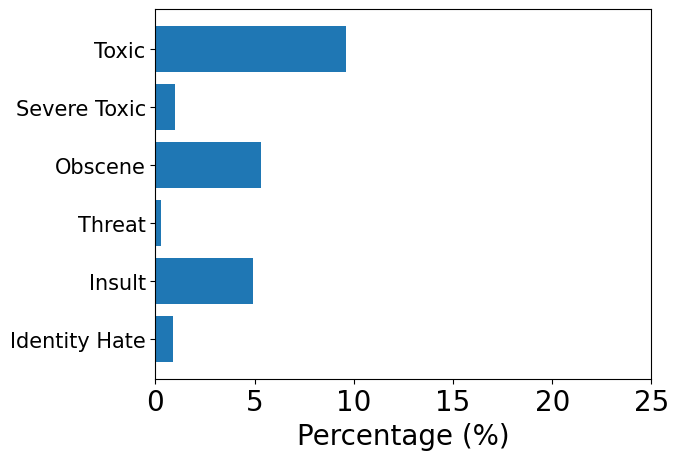

In [ ]:
#Create bar graph
sum_tox = train_df['toxic'].sum() / num_rows * 100
sum_sev = train_df['severe_toxic'].sum() / num_rows * 100
sum_obs = train_df['obscene'].sum() / num_rows * 100
sum_thr = train_df['threat'].sum() / num_rows * 100
sum_ins = train_df['insult'].sum() / num_rows * 100
sum_ide = train_df['identity_hate'].sum() / num_rows * 100

ind = np.arange(6)

ax = plt.barh(ind, [sum_tox, sum_sev, sum_obs, sum_thr, sum_ins, sum_ide])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.yticks(ind, ('Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate'), size=15)

plt.gca().invert_yaxis()
plt.show()

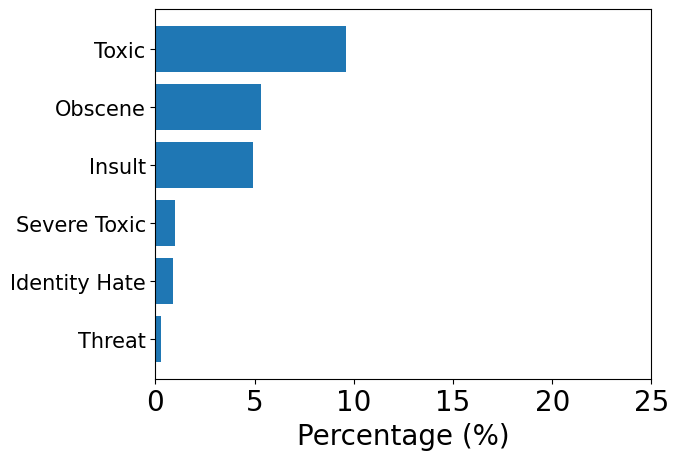

In [ ]:
#Create bar graph
sum_tox = train_df['toxic'].sum() / num_rows * 100
sum_sev = train_df['severe_toxic'].sum() / num_rows * 100
sum_obs = train_df['obscene'].sum() / num_rows * 100
sum_thr = train_df['threat'].sum() / num_rows * 100
sum_ins = train_df['insult'].sum() / num_rows * 100
sum_ide = train_df['identity_hate'].sum() / num_rows * 100

ind = np.arange(6)

ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins,  sum_sev, sum_ide , sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat'), size=15)

plt.gca().invert_yaxis()
plt.show()

# Giai đoạn tiền xử lý dữ liệu & chia section

In [ ]:
# Dựng hàm tiền xử lý Chuỗi comment

def text_preprocessing(text):
  # Chuyển đổi chữ thường
  text = text.lower()
  # Xóa tất cả các số có chữ cái gắn liền với chúng
  text = re.sub(r'\w*\d\w*', ' ', text)
  # Loại bỏ dấu câu
  text = strip_punctuation(text)
  # Loại bỏ kí tự xuống dòng
  text = re.sub("\n", " ", text)
  # Xóa kí tự không phải ascii
  text = strip_non_alphanum(text)
  # Loại bỏ các khoảng trắng thừa
  text = strip_multiple_whitespaces(text)
  return text

In [ ]:
# Áp dụng quá trình tiền xử lý chuỗi cho Dataframe

print('=== TRƯỚC KHI TIỀN XỬ LÝ ===')
print(train_df['comment_text'][0])

train_df['comment_text'] = train_df['comment_text'].apply(text_preprocessing)
test_df['comment_text_preprocessed'] = test_df['comment_text'].apply(text_preprocessing)

print('\n=== SAU KHI TIỀN XỬ LÝ ===')
train_df['comment_text'][0]

=== TRƯỚC KHI TIỀN XỬ LÝ ===
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

=== SAU KHI TIỀN XỬ LÝ ===


'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now '

In [ ]:
# Chia thanh 6 section
data_tox = train_df.loc[:,['id', 'comment_text', 'toxic']]
data_sev = train_df.loc[:,['id', 'comment_text', 'severe_toxic']]
data_obs = train_df.loc[:,['id', 'comment_text', 'obscene']]
data_ins = train_df.loc[:,['id', 'comment_text', 'insult']]
data_thr = train_df.loc[:,['id', 'comment_text', 'threat']]
data_ide = train_df.loc[:,['id', 'comment_text', 'identity_hate']]

print(data_tox.shape, data_sev.shape, data_obs.shape, data_ins.shape, data_thr.shape, data_ide.shape)

(159571, 3) (159571, 3) (159571, 3) (159571, 3) (159571, 3) (159571, 3)


# Tạo các WordCloud
**Những đám mây chứa rất nhiều từ ở các kích thước khác nhau, chúng thể hiện tần suất hoặc tầm quan trọng của mỗi từ.**

In [ ]:
def wordcloud(df, label):
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc=WordCloud(background_color='black',max_words=4000)
    wc.generate(" ".join(text))
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis('off')
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap='gist_earth', random_state=244), alpha=0.98)

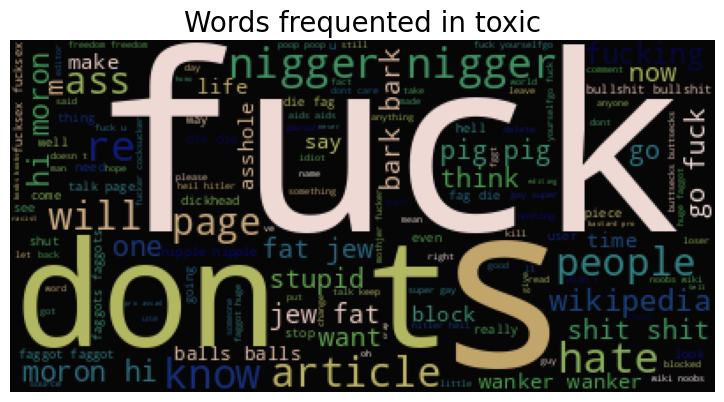

In [ ]:
wordcloud(data_tox,'toxic')

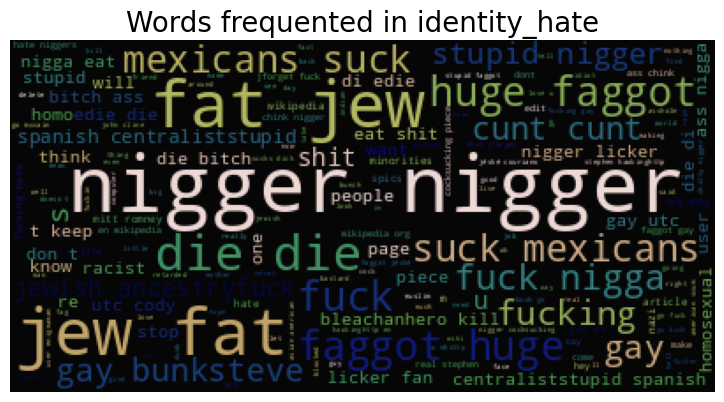

In [ ]:
wordcloud(data_ide,'identity_hate')

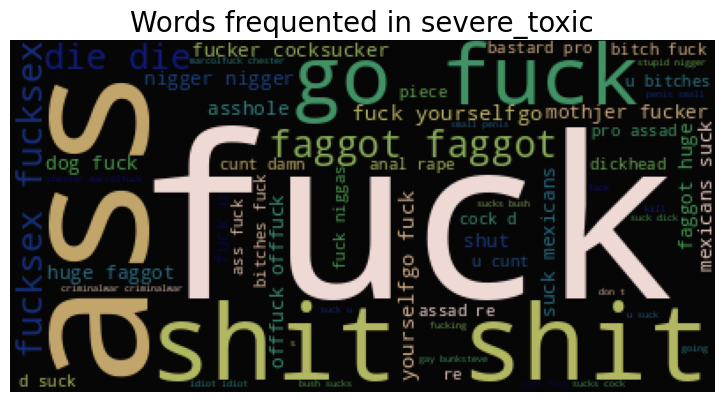

In [ ]:
wordcloud(data_sev,'severe_toxic')

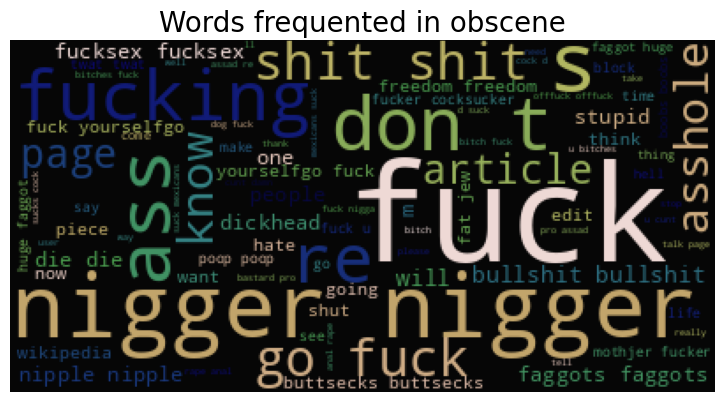

In [ ]:
wordcloud(data_obs,'obscene')

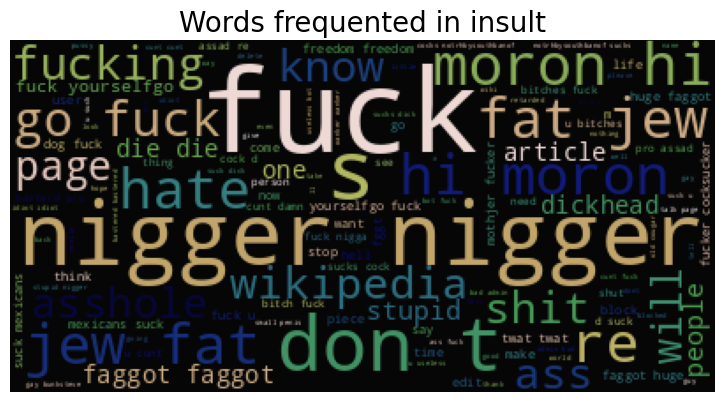

In [ ]:
wordcloud(data_ins,'insult')

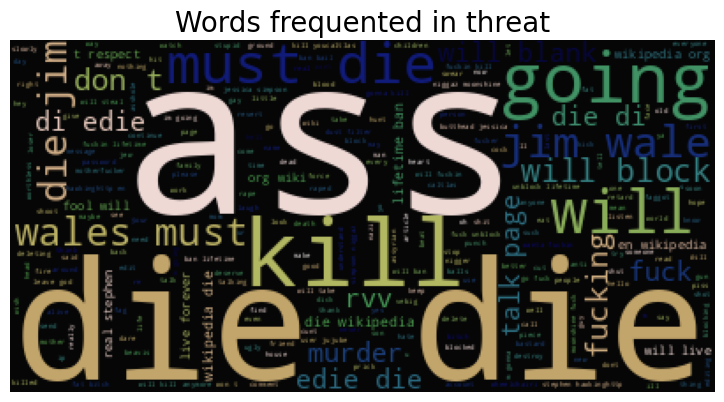

In [ ]:
wordcloud(data_thr,'threat')

# Trích chọn phần tử sao cho các lớp cân bằng nhau

In [ ]:
# Bảng tần số phân bổ các lớp ở từng thuộc tính

for col in train_df.columns[2:]:
  print(train_df[col].value_counts(normalize=True))

toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64
severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64
obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64
threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64
insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64
identity_hate
0    0.991195
1    0.008805
Name: proportion, dtype: float64


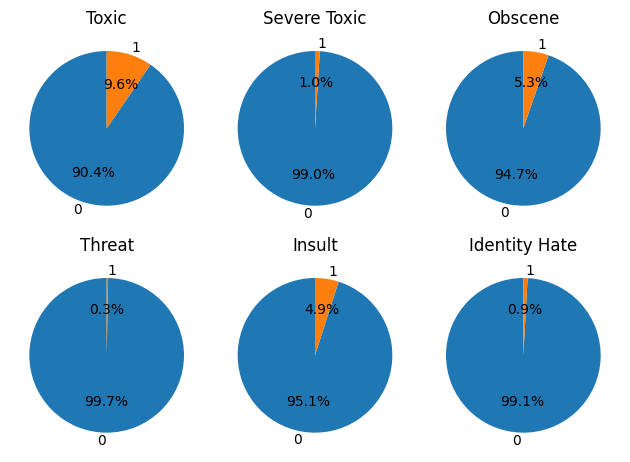

In [ ]:
# Mức độ phân bổ các lớp 0 và 1 ở từng thuộc tính (biểu đồ tròn)

toxic_counts = data_tox['toxic'].value_counts()
severe_toxic_counts = data_sev['severe_toxic'].value_counts()
obscene_counts = data_obs['obscene'].value_counts()
threat_counts = data_thr['threat'].value_counts()
insult_counts = data_ins['insult'].value_counts()
identity_hate_counts = data_ide['identity_hate'].value_counts()

fig, axes = plt.subplots(2, 3)

axes[0, 0].pie(toxic_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Toxic')

axes[0, 1].pie(severe_toxic_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Severe Toxic')

axes[0, 2].pie(obscene_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Obscene')

axes[1, 0].pie(threat_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Threat')

axes[1, 1].pie(insult_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Insult')

axes[1, 2].pie(identity_hate_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Identity Hate')

plt.tight_layout()
plt.show()


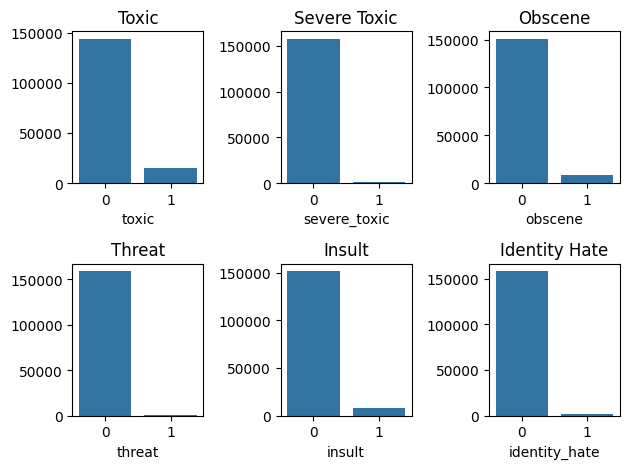

In [ ]:
# Mức độ phân bổ các lớp 0 và 1 ở từng thuộc tính (biểu đồ cột)

toxic_counts = data_tox['toxic'].value_counts()
severe_toxic_counts = data_sev['severe_toxic'].value_counts()
obscene_counts = data_obs['obscene'].value_counts()
threat_counts = data_thr['threat'].value_counts()
insult_counts = data_ins['insult'].value_counts()
identity_hate_counts = data_ide['identity_hate'].value_counts()

fig, axes = plt.subplots(2, 3)

sns.barplot(x=toxic_counts.index, y=toxic_counts.values, ax=axes[0, 0])
axes[0, 0].set_title('Toxic')

sns.barplot(x=severe_toxic_counts.index, y=severe_toxic_counts.values, ax=axes[0, 1])
axes[0, 1].set_title('Severe Toxic')

sns.barplot(x=obscene_counts.index, y=obscene_counts.values, ax=axes[0, 2])
axes[0, 2].set_title('Obscene')

sns.barplot(x=threat_counts.index, y=threat_counts.values, ax=axes[1, 0])
axes[1, 0].set_title('Threat')

sns.barplot(x=insult_counts.index, y=insult_counts.values, ax=axes[1, 1])
axes[1, 1].set_title('Insult')

sns.barplot(x=identity_hate_counts.index, y=identity_hate_counts.values, ax=axes[1, 2])
axes[1, 2].set_title('Identity Hate')

plt.tight_layout()
plt.show()


In [ ]:
## Thuộc tính Toxic

# In số phần tử nhỏ nhất của một lớp
min_toxic = data_tox['toxic'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_toxic)

# Trích chọn phần tử
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_tox_1.shape[0])
print('Lớp 0:', data_tox_0.shape[0])
print('Tổng:', data_tox_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  15294
THỐNG KÊ
Lớp 1: 5000
Lớp 0: 5000
Tổng: 10000


In [ ]:
## Thuộc tính Severve Toxic

# In số phần tử nhỏ nhất của một lớp
min_severve_toxic = data_sev['severe_toxic'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_severve_toxic)

# Trích chọn phần tử
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1500,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1500,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_sev_1.shape[0])
print('Lớp 0:', data_sev_0.shape[0])
print('Tổng:', data_sev_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  1595
THỐNG KÊ
Lớp 1: 1500
Lớp 0: 1500
Tổng: 3000


In [ ]:
## Thuộc tính Obscene

# In số phần tử nhỏ nhất của một lớp
min_obscene = data_obs['obscene'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_obscene)

# Trích chọn phần tử
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_obs_1.shape[0])
print('Lớp 0:', data_obs_0.shape[0])
print('Tổng:', data_obs_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  8449
THỐNG KÊ
Lớp 1: 5000
Lớp 0: 5000
Tổng: 10000


In [ ]:
## Thuộc tính threat

# In số phần tử nhỏ nhất của một lớp
min_threat = data_thr['threat'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_threat)

# Trích chọn phần tử
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:400,:]
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:400,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_thr_1.shape[0])
print('Lớp 0:', data_thr_0.shape[0])
print('Tổng:', data_thr_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  478
THỐNG KÊ
Lớp 1: 400
Lớp 0: 400
Tổng: 800


In [ ]:
## Thuộc tính insult

# In số phần tử nhỏ nhất của một lớp
min_insult = data_ins['insult'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_insult)

# Trích chọn phần tử
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_ins_1.shape[0])
print('Lớp 0:', data_ins_0.shape[0])
print('Tổng:', data_ins_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  7877
THỐNG KÊ
Lớp 1: 5000
Lớp 0: 5000
Tổng: 10000


In [ ]:
## Thuộc tính identity hate

# In số phần tử nhỏ nhất của một lớp
min_ide = data_ide['identity_hate'].value_counts().min()
print('Số phần tử nhỏ nhất của 1 lớp: ', min_ide)

# Trích chọn phần tử
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1000,:]
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:1000,:]

# Nối lại thành 1 tập data hoàn chỉnh bằng concat (Axis: Trục nối dọc)
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis = 0)

print('THỐNG KÊ')
print('Lớp 1:', data_ide_1.shape[0])
print('Lớp 0:', data_ide_0.shape[0])
print('Tổng:', data_ide_done.shape[0])

Số phần tử nhỏ nhất của 1 lớp:  1405
THỐNG KÊ
Lớp 1: 1000
Lớp 0: 1000
Tổng: 2000


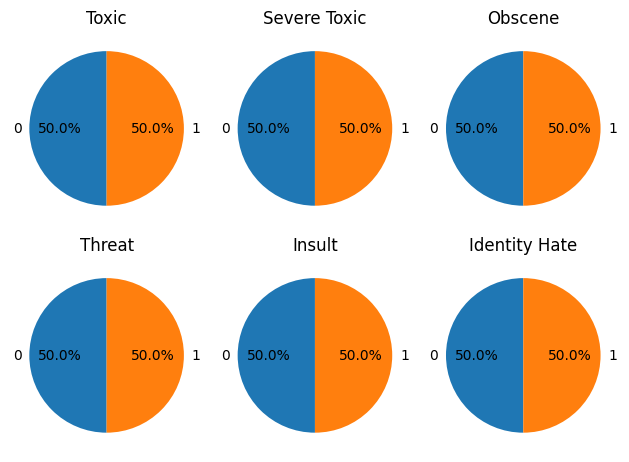

In [ ]:
# Mức độ phân bổ các lớp 0 và 1 ở từng thuộc tính sau khi tái cân bằng lớp (biểu đồ tròn)

toxic_counts = data_tox_done['toxic'].value_counts()
severe_toxic_counts = data_sev_done['severe_toxic'].value_counts()
obscene_counts = data_obs_done['obscene'].value_counts()
threat_counts = data_thr_done['threat'].value_counts()
insult_counts = data_ins_done['insult'].value_counts()
identity_hate_counts = data_ide_done['identity_hate'].value_counts()

fig, axes = plt.subplots(2, 3)

axes[0, 0].pie(toxic_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Toxic')

axes[0, 1].pie(severe_toxic_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Severe Toxic')

axes[0, 2].pie(obscene_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Obscene')

axes[1, 0].pie(threat_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Threat')

axes[1, 1].pie(insult_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Insult')

axes[1, 2].pie(identity_hate_counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Identity Hate')

plt.tight_layout()
plt.show()


# Train mô hình

### Train trên nhiều mô hình khác nhau, đánh giá & chọn ra mô hình tốt nhất

In [ ]:
def cv_tf_train_test(df_done,label,vectorizer,ngram=(1, 1)):
    # Hợp nhất tập dữ liệu X, y
    X = df_done.comment_text
    y = df_done[label]

    # Tách tập dữ liệu để Train/Test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30, random_state=42)

    # Vectơ hóa chuỗi đầu vào bằng TF-IDF
    # ngrams = (1, 1): unigram (chỉ chia văn bản thành các từ đơn lẻ thay vì cụm từ)
    # stop_words: Loại bỏ các từ dừng English (các từ thường xuyên xuất hiện nhưng mang ít thông tin)
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    # Tính toán TF-IDF & biến đổi sang ma trận gồm các vectơ đặc trưng
    X_train_cv1 = cv1.fit_transform(X_train)
    # Chỉ biến đổi văn bản sang ma trận sao cho phù hợp với không gian TF-IDF của tập Train
    X_test_sv1 = cv1.transform(X_test)

    # Train trên nhiều mô hình khác nhau
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)


    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)

    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)

    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state = 42)
    randomforest.fit(X_train_cv1, y_train)

    # Đánh giá chỉ số F1 Score các mô hình
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_sv1), y_test),
                                 f1_score(knn.predict(X_test_sv1), y_test),
                                 f1_score(bnb.predict(X_test_sv1), y_test),
                                 f1_score(mnb.predict(X_test_sv1), y_test),
                                 f1_score(svm_model.predict(X_test_sv1), y_test),
                                f1_score(randomforest.predict(X_test_sv1), y_test),]}

    # Convert dict qua pandas Dataframe để vẽ biểu đồ
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression', 'KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])

    return df_f1

In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Toxic

df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)
df_tox_cv

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,F1 Score(toxic)
Log Regression,0.860846
KNN,0.172781
BernoulliNB,0.776312
MultinomialNB,0.875252
SVM,0.877558
Random Forest,0.835110


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Severe Toxic

df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(Severe toxic)'}, inplace=True)
df_sev_cv

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,F1 Score(Severe toxic)
Log Regression,0.930804
KNN,0.856209
BernoulliNB,0.814748
MultinomialNB,0.936842
SVM,0.930997
Random Forest,0.930693


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Obscene

df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(Obscene)'}, inplace=True)
df_obs_cv

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,F1 Score(Obscene)
Log Regression,0.908655
KNN,0.239180
BernoulliNB,0.787944
MultinomialNB,0.902344
SVM,0.920656
Random Forest,0.908723


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Insult

df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(Insult)'}, inplace=True)
df_ins_cv

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,F1 Score(Insult)
Log Regression,0.896599
KNN,0.225287
BernoulliNB,0.783857
MultinomialNB,0.896755
SVM,0.902988
Random Forest,0.887064


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Threat

df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(Threat)'}, inplace=True)
df_thr_cv

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,F1 Score(Threat)
Log Regression,0.912134
KNN,0.873016
BernoulliNB,0.821192
MultinomialNB,0.931818
SVM,0.931174
Random Forest,0.915254


In [ ]:
# Bắt đầu fit mô hình trên thuộc tính Identity hate

df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(Identity Hate)'}, inplace=True)
df_ide_cv

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,F1 Score(Identity Hate)
Log Regression,0.874355
KNN,0.792857
BernoulliNB,0.765957
MultinomialNB,0.891720
SVM,0.890365
Random Forest,0.883562


In [ ]:
# Hợp nhất các dataframe f1 score ở từng thuộc tính

f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all

,F1 Score(toxic),F1 Score(Severe toxic),F1 Score(Obscene),F1 Score(Insult),F1 Score(Threat),F1 Score(Identity Hate)
Log Regression,0.860846,0.930804,0.908655,0.896599,0.912134,0.874355
KNN,0.172781,0.856209,0.239180,0.225287,0.873016,0.792857
BernoulliNB,0.776312,0.814748,0.787944,0.783857,0.821192,0.765957
MultinomialNB,0.875252,0.936842,0.902344,0.896755,0.931818,0.891720
SVM,0.877558,0.930997,0.920656,0.902988,0.931174,0.890365
Random Forest,0.835110,0.930693,0.908723,0.887064,0.915254,0.883562


In [ ]:
# Hoán vị các trục để bắt đầu dựng biểu đồ

f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.860846,0.172781,0.776312,0.875252,0.877558,0.835110
F1 Score(Severe toxic),0.930804,0.856209,0.814748,0.936842,0.930997,0.930693
F1 Score(Obscene),0.908655,0.239180,0.787944,0.902344,0.920656,0.908723
F1 Score(Insult),0.896599,0.225287,0.783857,0.896755,0.902988,0.887064
F1 Score(Threat),0.912134,0.873016,0.821192,0.931818,0.931174,0.915254
F1 Score(Identity Hate),0.874355,0.792857,0.765957,0.891720,0.890365,0.883562


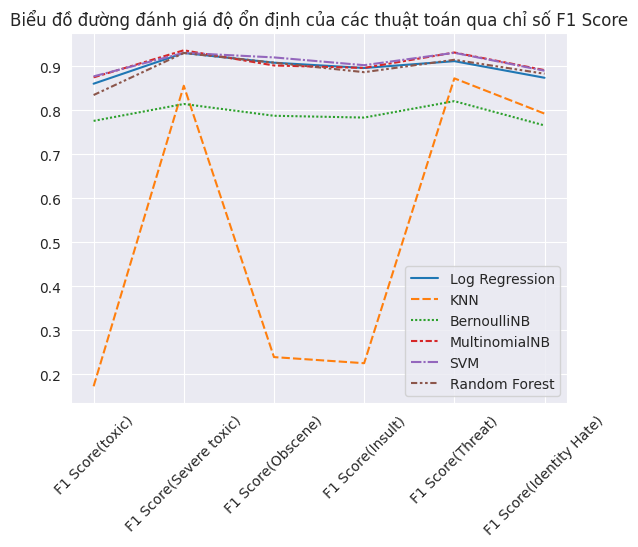

In [ ]:
# Vẽ biểu đồ đường đánh giá độ ổn định của các thuật toán qua chỉ số F1 Score

sns.set_style('darkgrid')
sns.lineplot(data=f1_all_trp)
plt.xticks(ticks=range(len(f1_all_trp)), labels=f1_all_trp.index, rotation=45)
plt.legend(loc='best')
plt.title('Biểu đồ đường đánh giá độ ổn định của các thuật toán qua chỉ số F1 Score')

plt.show()

### Train lại trên mô hình tốt nhất (Random Forest)

=== Đánh giá mô hình trên thuộc tính toxic ===
Accuracy: 0.8453333333333334
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1723
           1       0.76      0.92      0.84      1277

    accuracy                           0.85      3000
   macro avg       0.85      0.86      0.84      3000
weighted avg       0.86      0.85      0.85      3000



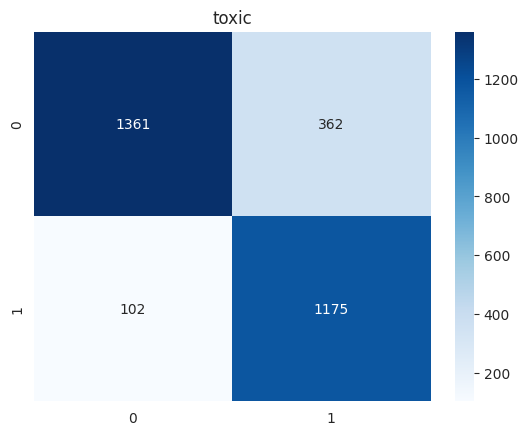

=== Đánh giá mô hình trên thuộc tính severe_toxic ===
Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       452
           1       0.92      0.94      0.93       448

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



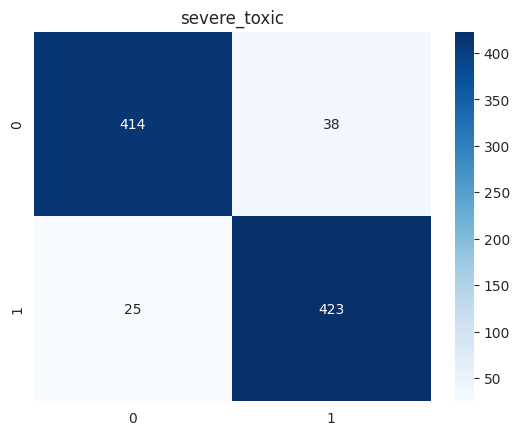

=== Đánh giá mô hình trên thuộc tính obscene ===
Accuracy: 0.9096666666666666
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1568
           1       0.88      0.94      0.91      1432

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



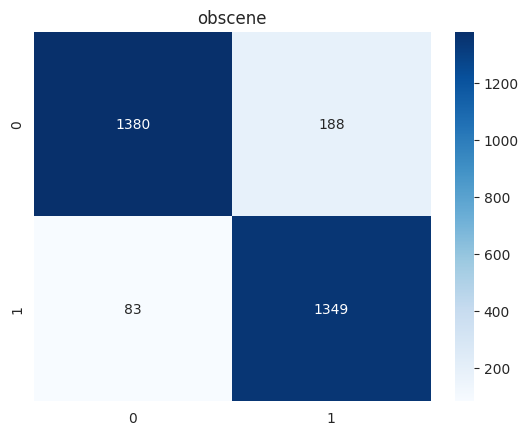

=== Đánh giá mô hình trên thuộc tính insult ===
Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1615
           1       0.84      0.94      0.89      1385

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



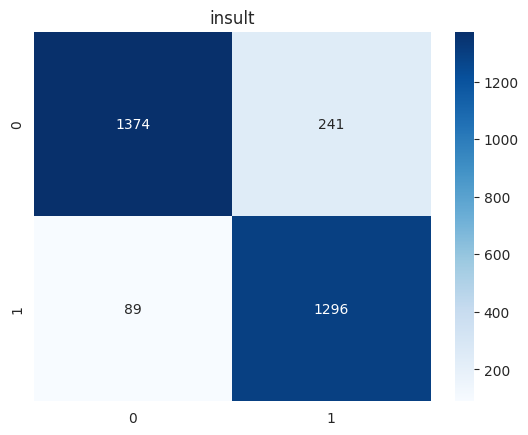

=== Đánh giá mô hình trên thuộc tính threat ===
Accuracy: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       129
           1       0.86      0.97      0.92       111

    accuracy                           0.92       240
   macro avg       0.92      0.92      0.92       240
weighted avg       0.92      0.92      0.92       240



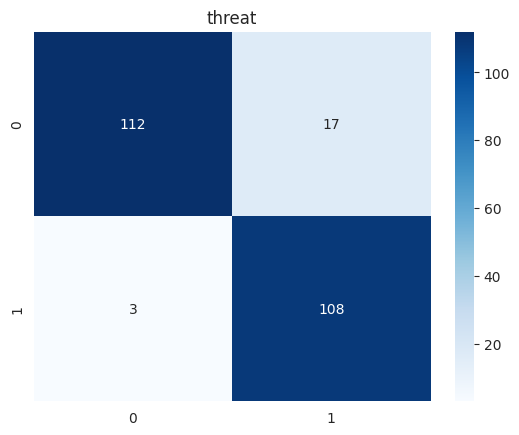

=== Đánh giá mô hình trên thuộc tính identity_hate ===
Accuracy: 0.8866666666666667
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       318
           1       0.85      0.91      0.88       282

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



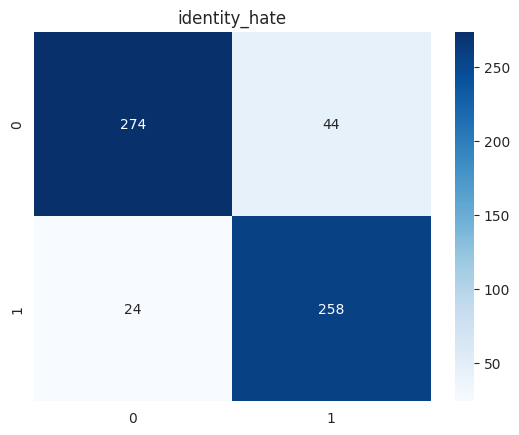

In [ ]:
data_dict = {
    'toxic': data_tox_done,
    'severe_toxic': data_sev_done,
    'obscene': data_obs_done,
    'insult': data_ins_done,
    'threat': data_thr_done,
    'identity_hate': data_ide_done
}

# Fit lại mô hình Random Forest
def fit_data_with_randomforest(X, y, label):
  # Tách tập dữ liệu để Train/Test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Vectơ hóa dữ liệu chuỗi
  tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

  X_train_fit = tfv.fit_transform(X_train)
  X_test_fit = tfv.transform(X_test)

  # Bắt đầu Train mô hình Random Forest
  randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
  randomforest.fit(X_train_fit, y_train)
  pred_test = randomforest.predict(X_test_fit)

  print(f'=== Đánh giá mô hình trên thuộc tính {label} ===')
  # Đánh giá bằng thang đo Accuracy
  print('Accuracy:', accuracy_score(pred_test, y_test))

  # In bảng thống kê phân loại
  print(classification_report(pred_test, y_test))

  # Vẽ ma trận nhầm lẫn
  cm = confusion_matrix(pred_test, y_test)
  plt.title(label)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.show()

  return randomforest, tfv

for idx, value in data_dict.items():
  # Bắt đầu Train mô hình Random Forest trên các thuộc tính
  model_fitted, tfv = fit_data_with_randomforest(value['comment_text'], value[idx], idx)

  # Lưu mô hình
  with open(os.path.join(model_path, f'{idx}_model.pkl'), 'wb') as f:
    pickle.dump([model_fitted, tfv], f)


# Dự đoán dữ liệu mới (Random Forest)

In [ ]:
# Dự đoán dữ liệu mới

models_list = ['toxic', 'severe_toxic', 'obscene', 'insult', 'threat', 'identity_hate']
models_data = {}

# Nạp mô hình đã Train vào bộ nhớ
for model in models_list:
  with open(os.path.join(model_path, f'{model}_model.pkl'), 'rb') as f:
    models_data[model] = pickle.load(f)

while True:
  input_text = input('Nhập dữ liệu mới: ')

  if input_text.lower() == "exit":
    break

  print('Input:', input_text)
  print('== Output ==')
  for idx, value in models_data.items():
    model_name, model, tfv = idx, value[0], value[1]
    text_preprocessed = text_preprocessing(input_text)
    text_vectorized = tfv.transform([text_preprocessed])
    result = model.predict_proba(text_vectorized)[:, 1]
    print(model_name,':',np.round(result, 3)[0])
  print('\n')

Nhập dữ liệu mới: fuck you nigga
Input: fuck you nigga
== Output ==
toxic : 1.0
severe_toxic : 0.983
obscene : 1.0
insult : 0.99
threat : 0.37
identity_hate : 0.87


Nhập dữ liệu mới: i love you
Input: i love you
== Output ==
toxic : 0.381
severe_toxic : 0.335
obscene : 0.347
insult : 0.254
threat : 0.19
identity_hate : 0.372


Nhập dữ liệu mới: exit
